# Re-implementation of the method proposed in ''DreamDiffusion: Generating High-Quality Images from Brain EEG Signals'' by Y. Bai, X. Wang et al.
*By Daniele Santino Cardullo | 2127806 | cardullo.2127806@studenti.uniroma1.it*

*original work: [DreamDiffusion (arXiv)](https://arxiv.org/abs/2306.16934)*

## Abstract

## Description of the implemented models and architectures

## How to run my code

## Implementation
### Downloads
Here are some links to download the datasets and pretrained models (extract them in the same folder where this notebook is):
- pretrained_models folder: 
- datasets folder:

These are needed to run the `Using the already pretrained model` block you'll find at the end of every step, this block is intended to be standalone hence can be run without running the precedings blocks. 

### First stage: Pretraining
The first stage in this work is the construction and pretraining of the *masked autoencoder for EEG signals*.
The datasets used for pretraining are selected from the MOABB family, a set of workbench for brain-computer interfaces development. In this implementation the model has been scaled with respect to the original work, still achieving good results both in terms of pretraining performances and final results.

The first step for pretraining is to load the datasets that will be used, in this case 5 subjects are selected from `BI2015b` dataset and 2 subjects are selected from `Lee2019_SSVEP`. The data is preprocessed in the dataset creation, filtering the signals between 5-95 Hz and limiting their timestep to 500 ticks; also each signal has been padded to have 128 channels by repeating it.

In [ ]:
import torch
from lightning.pytorch import seed_everything
from source.datasets.pretraining_dataset import EegPretrainDataset
from hydra import compose, initialize

with initialize(version_base=None, config_path="./", job_name="dream_diffusion"):
    cfg = compose(config_name="default_config")

# Seeding for repeatability
generator = torch.manual_seed(cfg.pretrain.seed)
seed_everything(cfg.pretrain.seed, workers=True)

ds = EegPretrainDataset(
    dim=cfg.pretrain.time_dimension, 
    train_perc=cfg.pretrain.train_perc)  # Preparation of the dataset (loading of data and preprocessing)

train_ds, test_ds = ds()    # Train and Test splitting

After having loaded the dataset it is possible to create the dataloaders for training and testing, in order to automatically create batches.

In [ ]:
from torch.utils.data import DataLoader


train_dl = DataLoader(train_ds, shuffle=True, batch_size=cfg.pretrain.bsz, generator=generator, num_workers=11)
test_dl = DataLoader(test_ds, batch_size=cfg.pretrain.bsz, generator=generator, num_workers=11)

After having loaded the data, we can finally instance the MAE model, along with the trainer. In this project Lightning has been used to enhance the training process limiting all the boilerplate code.

In [ ]:
from source.eeg_mae.masked_decoder import MaskedDecoder
from source.eeg_mae.masked_encoder import MaskedEncoder
from source.eeg_mae.encoder_config import EncoderConfig
from source.eeg_mae.eeg_autoencoder import EegAutoEncoder
from lightning.pytorch import Trainer

config = EncoderConfig(time_dim=cfg.pretrain.time_dimension, 
                       token_num=cfg.pretrain.time_dimension//4, 
                       embed_dim=cfg.mae.embed_dim, 
                       encoder_depth=cfg.mae.encoder_depth, 
                       encoder_heads=cfg.mae.encoder_heads, 
                       mask_perc=cfg.mae.mask_perc)
encoder = MaskedEncoder(config)
decoder = MaskedDecoder(cfg.pretrain.time_dimension, 
                        cfg.pretrain.time_dimension//4, 
                        cfg.mae.channels, 
                        cfg.mae.embed_dim,
                        cfg.mae.decoder_depth, 
                        cfg.mae.decoder_heads)

model = EegAutoEncoder(encoder, decoder, learning_rate=cfg.pretrain.lr)
trainer = Trainer(
    max_epochs=cfg.pretrain.epochs,
    log_every_n_steps=1,
    deterministic=True,
    enable_checkpointing=True, 
    gradient_clip_val=0.5,
    check_val_every_n_epoch=1
    )

And now it is possible to start the pretraining process:

In [ ]:
trainer.fit(model, train_dl, val_dataloaders=train_dl)

#### Using the already pretrained model
If you have downloaded the `pretrained_models` and `datasets` folders from the link in `Downloads` section, it is possible to directly load the already pretrained model and test it.

In [1]:
"""
Dataset Loading
"""
import torch
from lightning.pytorch import seed_everything
from source.datasets.pretraining_dataset import EegPretrainDataset
from hydra import compose, initialize
from source.eeg_mae.masked_decoder import MaskedDecoder
from source.eeg_mae.masked_encoder import MaskedEncoder
from source.eeg_mae.encoder_config import EncoderConfig
from source.eeg_mae.eeg_autoencoder import EegAutoEncoder
from lightning.pytorch import Trainer
from hydra import compose, initialize

with initialize(version_base=None, config_path="./", job_name="dream_diffusion"):
    cfg = compose(config_name="default_config")

generator = torch.manual_seed(cfg.pretrain.seed)
seed_everything(cfg.pretrain.seed, workers=True)

ds = EegPretrainDataset(
    dim=cfg.pretrain.time_dimension, 
    train_perc=cfg.pretrain.train_perc, ds_path='./datasets/pretrain_dataset.pth')

<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
/home/osusume/Desktop/nn_project_dreamdiffusion/.venv/lib/python3.10/site-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.


Seed set to 0


Dataset loaded from file


In [4]:
"""
Model Loading
"""
from torch.utils.data import DataLoader

train_ds, test_ds = ds()
train_dl = DataLoader(train_ds, shuffle=True, batch_size=cfg.pretrain.bsz, generator=generator, num_workers=11)
test_dl = DataLoader(test_ds, batch_size=cfg.pretrain.bsz, generator=generator, num_workers=11)

config = EncoderConfig(time_dim=cfg.pretrain.time_dimension, 
                       token_num=cfg.pretrain.time_dimension//4, 
                       embed_dim=cfg.mae.embed_dim, 
                       encoder_depth=cfg.mae.encoder_depth, 
                       encoder_heads=cfg.mae.encoder_heads, 
                       mask_perc=cfg.mae.mask_perc)
encoder = MaskedEncoder(config)
decoder = MaskedDecoder(cfg.pretrain.time_dimension, 
                        cfg.pretrain.time_dimension//4, 
                        cfg.mae.channels, 
                        cfg.mae.embed_dim,
                        cfg.mae.decoder_depth, 
                        cfg.mae.decoder_heads)

model = EegAutoEncoder.load_from_checkpoint('./pretrained_models/pretrained_mae.ckpt', encoder=encoder, decoder=decoder, learning_rate=2.5e-3)

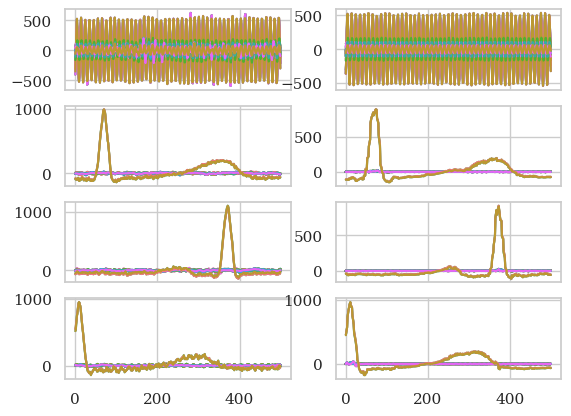

In [16]:
"""
Results
"""
import matplotlib.pyplot as plt

batch = next(iter(test_dl))
model.eval()

with torch.no_grad():
    prediction = model(batch.to('cuda')).detach().cpu()
    
fig, axes = plt.subplots(4, 2, sharex=True)

for i in range(4):
    axes[i, 0].plot(batch[i, :, :])
    axes[i, 1].plot(prediction[i, :, :])

plt.show()

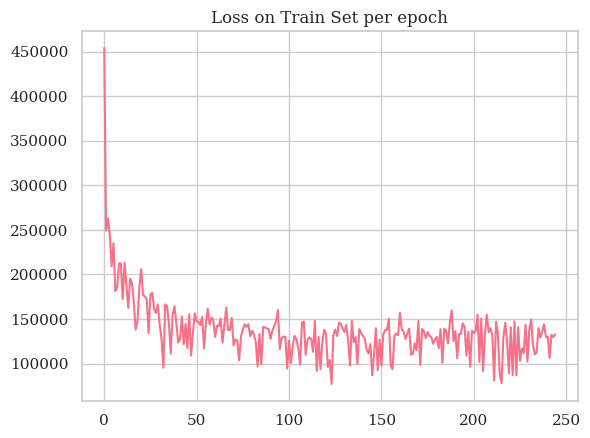

In [12]:
import pandas as pd 

df = pd.read_csv('./pretrained_models/train_loss_mae.csv', sep=',')

plt.plot(df['Value'])
plt.title('Loss on Train Set per epoch')
plt.show()